# Generate segmentation
with optimal found parameters

author = Caroline Magg <br>
date = 28 May 2020 <br>

___________________________________
history: <br>
2020-28-05 Run first segmentation <br>
2020-01-06 Run segmentation and save images <br>
2020-02-06 Run segmentation with correct params and save images T0<br>
2020-27-07 Run segmentation with better params and save images (finer grid search) folder 1-10<br>
2020-27-07 Run segmentation with params and save images T1 folder 1-10<br>
2020-29-07 Run segmentation with params and save images T0, T1 folder 11-14 <br>
2020-29-07 Create csv with structure-wise data <br>
2020-20-08 Run segmentation again with k = 1 <br>
2020-27-08 Run segmentation with fixed bug for last slice <br>
2020-11-09 Run segmentation for 15-20 <br>

In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import pydicom
from natsort import natsorted
import scipy
import time
import logging as log
import skimage.segmentation as segmentation
import itertools

In [2]:
log.basicConfig(format='%(levelname)s:%(message)s', level=log.INFO)

### Add dependencies

In [3]:
# add KidsBrainProject main folder to paths
sys.path.append(os.path.abspath('../../'))
sys.path.append(os.path.abspath('../utils/'))

In [4]:
from PatientData import PatientData
from DicomWrapper import DicomWrapper
from Segmentation import Segmentation
from HyperparameterSearchSegmentation import HyperparameterSearchSegmentation as HyperparamSearch

In [5]:
# add path to data here
path_data = "../../Data/" 

### Contour list

In [6]:
contours_list = pd.read_csv("list_contours.csv",delimiter=',')
contours_list

,Number,RoiName,Values
0,1,Brain,"(4, 0.05, 4)"
1,2,Cerebell POST YL,"(4, 0.05, 4)"
2,3,Cingulum left,"(10, 0.1, 10)"
3,4,Cingulum right,"(10, 0.2, 10)"
4,5,Corpus callosum,"(4, 0.05, 4)"
5,6,CTV,"(10, 0.05, 10)"
6,7,CTV1,"(10, 0.05, 10)"
7,8,CTV2,"(10, 0.2, 10)"
8,9,Fornix,"(4, 0.05, 4)"
9,10,GTV,"(10, 0.2, 10)"


### Review the hyperparameter search

In [7]:
contour_of_interest = contours_list['RoiName'].values
values_of_interest = contours_list['Values'].values
print(contour_of_interest)
print(values_of_interest)
len(contour_of_interest)

['Brain' 'Cerebell POST YL' 'Cingulum left' 'Cingulum right'
 'Corpus callosum' 'CTV' 'CTV1' 'CTV2' 'Fornix' 'GTV' 'Hypothalamus'
 'PapezCircle' 'PTV1' 'PTV2' 'Scalp' 'TemporalLobeLt' 'TemporalLobeRt'
 'Thalamus ant L' 'Thalamus ant R' 'Thalamus left' 'Thalamus right']
['(4, 0.05, 4)' '(4, 0.05, 4)' '(10, 0.1, 10)' '(10, 0.2, 10)'
 '(4, 0.05, 4)' '(10, 0.05, 10)' '(10, 0.05, 10)' '(10, 0.2, 10)'
 '(4, 0.05, 4)' '(10, 0.2, 10)' '(10, 0.05, 10)' '(10, 0.05, 10)'
 '(10, 0.05, 10)' '(10, 0.05, 10)' '(4, 0.05, 4)' '(10, 0.05, 10)'
 '(4, 0.05, 4)' '(10, 0.05, 10)' '(10, 0.05, 10)' '(10, 0.2, 10)'
 '(10, 0.2, 10)']


21

# Segmentation T0

In [9]:
compression_params = [cv2.IMWRITE_PNG_COMPRESSION, 0]

In [12]:
for idx in range(20,21):
    print("folder", idx)
    t = time.time()
    files = os.listdir(os.path.join(path_data, str(idx)))
    path_contour = os.path.join(path_data, str(idx), 'RS.Jacks{0}.dcm'.format(idx))
    path_preop = os.path.join(path_data, str(idx), 'CT')
    path_postop = [os.path.join(path_data, str(idx), fn) for fn in [x for x in files if 'T1' in x or 'MRT' in x]]
    
    data = PatientData(path_preop, path_postop, path_contour)
    data.read_filtered_contour(roiname=contour_of_interest, mode="exact")
    segmentor = Segmentation(data, debug=True)
    
    directory = os.path.join(path_data, str(idx), 'Segmentation')
    if not os.path.exists(directory):
        os.makedirs(directory)
    if not os.path.exists(os.path.join(directory, 'png')):
        os.makedirs(os.path.join(directory, 'png'))
    if not os.path.exists(os.path.join(directory, 'init')):
        os.makedirs(os.path.join(directory, 'init'))
    if not os.path.exists(os.path.join(directory, 't0')):
        os.makedirs(os.path.join(directory, 't0'))
        
    # dicom image -> png
    print("pngs images")
    img = data.get_pre_images()
    [cv2.imwrite(os.path.join(directory, 'png', '{0}_slice{1}.png'.format(idx,i)), img[i].astype(np.uint8), compression_params) for i in range(len(img))]

    # segmentations
    found_struct = data.get_filtered_contour_names().values
    first_index = data.contour_list_names_filtered['first'].values
    last_index = data.contour_list_names_filtered['last'].values
    # t0 segmentations
    print("t0 segmentation")
    for struct, first, last in zip(found_struct, first_index, last_index):
        tmp = contours_list[contours_list['RoiName'] == struct]['Values'].values[0]
        values = [float(x) for x in tmp.replace('(','').replace(')','').split(',')]
        cont = segmentor.active_contour(struct, postprocess=-1, first=first, last=last,
                       kernel=(int(values[0]),int(values[0])), beta=values[1], max_iterations=int(values[2])) 
        for i in range(len(cont)):
            cv2.imwrite(os.path.join(directory, 't0', '{0}_t0_{1}_slice{2}.png'.format(idx,struct,first+i)), 
                        cont[i].astype(np.uint8), 
                        compression_params)
        
    # init segmentation
    print("init segmentation")
    for ind, first, last in zip(range(len(first_index)), first_index, last_index):
        struct = found_struct[ind]
        for i in range(first, last+1):
            cv2.imwrite(os.path.join(directory, 'init', '{0}_init_{1}_slice{2}.png'.format(idx,struct,i)),
                        data.contour_list_names_filtered.iloc[ind]['mask'][i].astype(np.uint8),
                        compression_params)

INFO: Preop dicom


folder 20


INFO: Postop ../../Data/20\T1 BRAVO 4-30-15
INFO: Postop ../../Data/20\T1_MPR 2-25-15
INFO: Start reading contour list
INFO: Start filtering contour list for RoiNames ['Brain' 'Cerebell POST YL' 'Cingulum left' 'Cingulum right'
 'Corpus callosum' 'CTV' 'CTV1' 'CTV2' 'Fornix' 'GTV' 'Hypothalamus'
 'PapezCircle' 'PTV1' 'PTV2' 'Scalp' 'TemporalLobeLt' 'TemporalLobeRt'
 'Thalamus ant L' 'Thalamus ant R' 'Thalamus left' 'Thalamus right'] with mode exact


pngs images
t0 segmentation


INFO: Start segmentation of Brain.
INFO: Start segmentation of Cerebell POST YL.
INFO: Start segmentation of Corpus callosum.
INFO: Start segmentation of CTV.
INFO: Start segmentation of Fornix.
INFO: Start segmentation of GTV.
INFO: Start segmentation of Hypothalamus.
INFO: Start segmentation of PTV1.
INFO: Start segmentation of PTV2.
INFO: Start segmentation of Scalp.
INFO: Start segmentation of TemporalLobeLt.
INFO: Start segmentation of TemporalLobeRt.
INFO: Start segmentation of Thalamus ant L.
INFO: Start segmentation of Thalamus ant R.


init segmentation


# Segmentation T1+

In [13]:
for idx in range(15,21):
    if idx == 19:
        continue
    print("folder", idx)
    t = time.time()
    files = os.listdir(os.path.join(path_data, str(idx)))
    path_contour = os.path.join(path_data, str(idx), 'RS.Jacks{0}.dcm'.format(idx))
    path_preop = os.path.join(path_data, str(idx), 'CT')
    path_postop = [os.path.join(path_data, str(idx), fn) for fn in [x for x in files if 'T1' in x or 'MRT1' in x]]
    
    data = PatientData(path_preop, path_postop, path_contour)
    data.read_filtered_contour(roiname=contour_of_interest, mode="exact")
    segmentor = Segmentation(data, debug=True)
    
    # segmentations of t0
    found_struct = data.get_filtered_contour_names().values
    first_index = data.contour_list_names_filtered['first'].values
    last_index = data.contour_list_names_filtered['last'].values
    
    directory = os.path.join(path_data, str(idx), 'Segmentation')  
    
    # t1+ segmentations and images
    for postop in range(len(data._postop_dicoms)):
        print("t{0} segmentations".format(postop+1))
        d = path_postop[postop].split('\\')[-1].split(' ')[-1]
        name = 't1 '+ d
        name02 = 'png ' + d
        if not os.path.exists(os.path.join(directory, name)):
            os.makedirs(os.path.join(directory, name))
        if not os.path.exists(os.path.join(directory, name02)):
            os.makedirs(os.path.join(directory, name02))
        # segmentation
        for struct, first, last in zip(found_struct, first_index, last_index):
            tmp = contours_list[contours_list['RoiName'] == struct]['Values'].values[0]
            values = [float(x) for x in tmp.replace('(','').replace(')','').split(',')]
            cont = segmentor.active_contour(struct, postprocess=postop, first=first, last=last,
                           kernel=(int(values[0]),int(values[0])), beta=values[1], max_iterations=int(values[2])) 
            for i in range(len(cont)):
                cv2.imwrite(os.path.join(directory, name, '{0}_t1_{3}_{1}_slice{2}.png'.format(idx,struct,first+i,d)), 
                            cont[i].astype(np.uint8), 
                            compression_params)
        # images
        img = data.get_post_images()
        [cv2.imwrite(os.path.join(directory, name02, '{0}_slice{1}.png'.format(idx,ix)), img[postop][ix].astype(np.uint8), compression_params) for ix in range(np.shape(img)[1])]

INFO: Preop dicom


folder 15


INFO: Postop ../../Data/15\T1 +C 12-31-15
INFO: Postop ../../Data/15\T1 AX 11-20-15
INFO: Postop ../../Data/15\T1 AX 12-31-15
INFO: Postop ../../Data/15\T1 COR 11-20-15
INFO: Postop ../../Data/15\T1 SAG 11-20-15
INFO: Start reading contour list
INFO: Start filtering contour list for RoiNames ['Brain' 'Cerebell POST YL' 'Cingulum left' 'Cingulum right'
 'Corpus callosum' 'CTV' 'CTV1' 'CTV2' 'Fornix' 'GTV' 'Hypothalamus'
 'PapezCircle' 'PTV1' 'PTV2' 'Scalp' 'TemporalLobeLt' 'TemporalLobeRt'
 'Thalamus ant L' 'Thalamus ant R' 'Thalamus left' 'Thalamus right'] with mode exact


t1 segmentations


INFO: Start segmentation of Brain.
INFO: Start segmentation of Cerebell POST YL.
INFO: Start segmentation of Corpus callosum.
INFO: Start segmentation of CTV.
INFO: Start segmentation of Fornix.
INFO: Start segmentation of GTV.
INFO: Start segmentation of Hypothalamus.
INFO: Start segmentation of PTV1.
INFO: Start segmentation of PTV2.
INFO: Start segmentation of Scalp.
INFO: Start segmentation of TemporalLobeLt.
INFO: Start segmentation of TemporalLobeRt.
INFO: Start segmentation of Thalamus ant L.
INFO: Start segmentation of Thalamus ant R.


t2 segmentations


INFO: Start segmentation of Brain.
INFO: Start segmentation of Cerebell POST YL.
INFO: Start segmentation of Corpus callosum.
INFO: Start segmentation of CTV.
INFO: Start segmentation of Fornix.
INFO: Start segmentation of GTV.
INFO: Start segmentation of Hypothalamus.
INFO: Start segmentation of PTV1.
INFO: Start segmentation of PTV2.
INFO: Start segmentation of Scalp.
INFO: Start segmentation of TemporalLobeLt.
INFO: Start segmentation of TemporalLobeRt.
INFO: Start segmentation of Thalamus ant L.
INFO: Start segmentation of Thalamus ant R.


t3 segmentations


INFO: Start segmentation of Brain.
INFO: Start segmentation of Cerebell POST YL.
INFO: Start segmentation of Corpus callosum.
INFO: Start segmentation of CTV.
INFO: Start segmentation of Fornix.
INFO: Start segmentation of GTV.
INFO: Start segmentation of Hypothalamus.
INFO: Start segmentation of PTV1.
INFO: Start segmentation of PTV2.
INFO: Start segmentation of Scalp.
INFO: Start segmentation of TemporalLobeLt.
INFO: Start segmentation of TemporalLobeRt.
INFO: Start segmentation of Thalamus ant L.
INFO: Start segmentation of Thalamus ant R.


t4 segmentations


INFO: Start segmentation of Brain.
INFO: Start segmentation of Cerebell POST YL.
INFO: Start segmentation of Corpus callosum.
INFO: Start segmentation of CTV.
INFO: Start segmentation of Fornix.
INFO: Start segmentation of GTV.
INFO: Start segmentation of Hypothalamus.
INFO: Start segmentation of PTV1.
INFO: Start segmentation of PTV2.
INFO: Start segmentation of Scalp.
INFO: Start segmentation of TemporalLobeLt.
INFO: Start segmentation of TemporalLobeRt.
INFO: Start segmentation of Thalamus ant L.
INFO: Start segmentation of Thalamus ant R.


t5 segmentations


INFO: Start segmentation of Brain.
INFO: Start segmentation of Cerebell POST YL.
INFO: Start segmentation of Corpus callosum.
INFO: Start segmentation of CTV.
INFO: Start segmentation of Fornix.
INFO: Start segmentation of GTV.
INFO: Start segmentation of Hypothalamus.
INFO: Start segmentation of PTV1.
INFO: Start segmentation of PTV2.
INFO: Start segmentation of Scalp.
INFO: Start segmentation of TemporalLobeLt.
INFO: Start segmentation of TemporalLobeRt.
INFO: Start segmentation of Thalamus ant L.
INFO: Start segmentation of Thalamus ant R.
INFO: Preop dicom


folder 16


INFO: Postop ../../Data/16\T1 11-26-15
INFO: Postop ../../Data/16\T1 Ax 09-13-15
INFO: Postop ../../Data/16\T1 Sag 09-18-15
INFO: Postop ../../Data/16\T1 Sag 10-09-15
INFO: Start reading contour list
INFO: Start filtering contour list for RoiNames ['Brain' 'Cerebell POST YL' 'Cingulum left' 'Cingulum right'
 'Corpus callosum' 'CTV' 'CTV1' 'CTV2' 'Fornix' 'GTV' 'Hypothalamus'
 'PapezCircle' 'PTV1' 'PTV2' 'Scalp' 'TemporalLobeLt' 'TemporalLobeRt'
 'Thalamus ant L' 'Thalamus ant R' 'Thalamus left' 'Thalamus right'] with mode exact


t1 segmentations


INFO: Start segmentation of Brain.
INFO: Start segmentation of Cerebell POST YL.
INFO: Start segmentation of Corpus callosum.
INFO: Start segmentation of CTV.
INFO: Start segmentation of Fornix.
INFO: Start segmentation of GTV.
INFO: Start segmentation of Hypothalamus.
INFO: Start segmentation of PTV1.
INFO: Start segmentation of PTV2.
INFO: Start segmentation of Scalp.
INFO: Start segmentation of TemporalLobeLt.
INFO: Start segmentation of TemporalLobeRt.


t2 segmentations


INFO: Start segmentation of Brain.
INFO: Start segmentation of Cerebell POST YL.
INFO: Start segmentation of Corpus callosum.
INFO: Start segmentation of CTV.
INFO: Start segmentation of Fornix.
INFO: Start segmentation of GTV.
INFO: Start segmentation of Hypothalamus.
INFO: Start segmentation of PTV1.
INFO: Start segmentation of PTV2.
INFO: Start segmentation of Scalp.
INFO: Start segmentation of TemporalLobeLt.
INFO: Start segmentation of TemporalLobeRt.


t3 segmentations


INFO: Start segmentation of Brain.
INFO: Start segmentation of Cerebell POST YL.
INFO: Start segmentation of Corpus callosum.
INFO: Start segmentation of CTV.
INFO: Start segmentation of Fornix.
INFO: Start segmentation of GTV.
INFO: Start segmentation of Hypothalamus.
INFO: Start segmentation of PTV1.
INFO: Start segmentation of PTV2.
INFO: Start segmentation of Scalp.
INFO: Start segmentation of TemporalLobeLt.
INFO: Start segmentation of TemporalLobeRt.


t4 segmentations


INFO: Start segmentation of Brain.
INFO: Start segmentation of Cerebell POST YL.
INFO: Start segmentation of Corpus callosum.
INFO: Start segmentation of CTV.
INFO: Start segmentation of Fornix.
INFO: Start segmentation of GTV.
INFO: Start segmentation of Hypothalamus.
INFO: Start segmentation of PTV1.
INFO: Start segmentation of PTV2.
INFO: Start segmentation of Scalp.
INFO: Start segmentation of TemporalLobeLt.
INFO: Start segmentation of TemporalLobeRt.


folder 17


INFO: Preop dicom
INFO: Postop ../../Data/17\Ax T1+C 08-17-15
INFO: Postop ../../Data/17\T1 FLAIR +C 9-25-15
INFO: Postop ../../Data/17\T1+C 08-17-15
INFO: Postop ../../Data/17\T1+C 09-30-15
INFO: Start reading contour list
INFO: Start filtering contour list for RoiNames ['Brain' 'Cerebell POST YL' 'Cingulum left' 'Cingulum right'
 'Corpus callosum' 'CTV' 'CTV1' 'CTV2' 'Fornix' 'GTV' 'Hypothalamus'
 'PapezCircle' 'PTV1' 'PTV2' 'Scalp' 'TemporalLobeLt' 'TemporalLobeRt'
 'Thalamus ant L' 'Thalamus ant R' 'Thalamus left' 'Thalamus right'] with mode exact


t1 segmentations


INFO: Start segmentation of Brain.
INFO: Start segmentation of Cerebell POST YL.
INFO: Start segmentation of Corpus callosum.
INFO: Start segmentation of CTV.
INFO: Start segmentation of Fornix.
INFO: Start segmentation of GTV.
INFO: Start segmentation of Hypothalamus.
INFO: Start segmentation of PTV1.
INFO: Start segmentation of PTV2.
INFO: Start segmentation of Scalp.
INFO: Start segmentation of TemporalLobeLt.
INFO: Start segmentation of TemporalLobeRt.
INFO: Start segmentation of Thalamus ant L.
INFO: Start segmentation of Thalamus ant R.


t2 segmentations


INFO: Start segmentation of Brain.
INFO: Start segmentation of Cerebell POST YL.
INFO: Start segmentation of Corpus callosum.
INFO: Start segmentation of CTV.
INFO: Start segmentation of Fornix.
INFO: Start segmentation of GTV.
INFO: Start segmentation of Hypothalamus.
INFO: Start segmentation of PTV1.
INFO: Start segmentation of PTV2.
INFO: Start segmentation of Scalp.
INFO: Start segmentation of TemporalLobeLt.
INFO: Start segmentation of TemporalLobeRt.
INFO: Start segmentation of Thalamus ant L.
INFO: Start segmentation of Thalamus ant R.


t3 segmentations


INFO: Start segmentation of Brain.
INFO: Start segmentation of Cerebell POST YL.
INFO: Start segmentation of Corpus callosum.
INFO: Start segmentation of CTV.
INFO: Start segmentation of Fornix.
INFO: Start segmentation of GTV.
INFO: Start segmentation of Hypothalamus.
INFO: Start segmentation of PTV1.
INFO: Start segmentation of PTV2.
INFO: Start segmentation of Scalp.
INFO: Start segmentation of TemporalLobeLt.
INFO: Start segmentation of TemporalLobeRt.
INFO: Start segmentation of Thalamus ant L.
INFO: Start segmentation of Thalamus ant R.


t4 segmentations


INFO: Start segmentation of Brain.
INFO: Start segmentation of Cerebell POST YL.
INFO: Start segmentation of Corpus callosum.
INFO: Start segmentation of CTV.
INFO: Start segmentation of Fornix.
INFO: Start segmentation of GTV.
INFO: Start segmentation of Hypothalamus.
INFO: Start segmentation of PTV1.
INFO: Start segmentation of PTV2.
INFO: Start segmentation of Scalp.
INFO: Start segmentation of TemporalLobeLt.
INFO: Start segmentation of TemporalLobeRt.
INFO: Start segmentation of Thalamus ant L.
INFO: Start segmentation of Thalamus ant R.
INFO: Preop dicom


folder 18


INFO: Postop ../../Data/18\T1 MPR 6-11-15
INFO: Postop ../../Data/18\T1 MPR 9-10-12
INFO: Postop ../../Data/18\T1 SE 8-20-15
INFO: Start reading contour list
INFO: Start filtering contour list for RoiNames ['Brain' 'Cerebell POST YL' 'Cingulum left' 'Cingulum right'
 'Corpus callosum' 'CTV' 'CTV1' 'CTV2' 'Fornix' 'GTV' 'Hypothalamus'
 'PapezCircle' 'PTV1' 'PTV2' 'Scalp' 'TemporalLobeLt' 'TemporalLobeRt'
 'Thalamus ant L' 'Thalamus ant R' 'Thalamus left' 'Thalamus right'] with mode exact


t1 segmentations


INFO: Start segmentation of Brain.
INFO: Start segmentation of Cerebell POST YL.
INFO: Start segmentation of Corpus callosum.
INFO: Start segmentation of CTV.
INFO: Start segmentation of Fornix.
INFO: Start segmentation of GTV.
INFO: Start segmentation of Hypothalamus.
INFO: Start segmentation of PTV1.
INFO: Start segmentation of PTV2.
INFO: Start segmentation of Scalp.
INFO: Start segmentation of TemporalLobeLt.
INFO: Start segmentation of TemporalLobeRt.


t2 segmentations


INFO: Start segmentation of Brain.
INFO: Start segmentation of Cerebell POST YL.
INFO: Start segmentation of Corpus callosum.
INFO: Start segmentation of CTV.
INFO: Start segmentation of Fornix.
INFO: Start segmentation of GTV.
INFO: Start segmentation of Hypothalamus.
INFO: Start segmentation of PTV1.
INFO: Start segmentation of PTV2.
INFO: Start segmentation of Scalp.
INFO: Start segmentation of TemporalLobeLt.
INFO: Start segmentation of TemporalLobeRt.


t3 segmentations


INFO: Start segmentation of Brain.
INFO: Start segmentation of Cerebell POST YL.
INFO: Start segmentation of Corpus callosum.
INFO: Start segmentation of CTV.
INFO: Start segmentation of Fornix.
INFO: Start segmentation of GTV.
INFO: Start segmentation of Hypothalamus.
INFO: Start segmentation of PTV1.
INFO: Start segmentation of PTV2.
INFO: Start segmentation of Scalp.
INFO: Start segmentation of TemporalLobeLt.
INFO: Start segmentation of TemporalLobeRt.
INFO: Preop dicom


folder 20


INFO: Postop ../../Data/20\T1 BRAVO 4-30-15
INFO: Postop ../../Data/20\T1_MPR 2-25-15
INFO: Start reading contour list
INFO: Start filtering contour list for RoiNames ['Brain' 'Cerebell POST YL' 'Cingulum left' 'Cingulum right'
 'Corpus callosum' 'CTV' 'CTV1' 'CTV2' 'Fornix' 'GTV' 'Hypothalamus'
 'PapezCircle' 'PTV1' 'PTV2' 'Scalp' 'TemporalLobeLt' 'TemporalLobeRt'
 'Thalamus ant L' 'Thalamus ant R' 'Thalamus left' 'Thalamus right'] with mode exact


t1 segmentations


INFO: Start segmentation of Brain.
INFO: Start segmentation of Cerebell POST YL.
INFO: Start segmentation of Corpus callosum.
INFO: Start segmentation of CTV.
INFO: Start segmentation of Fornix.
INFO: Start segmentation of GTV.
INFO: Start segmentation of Hypothalamus.
INFO: Start segmentation of PTV1.
INFO: Start segmentation of PTV2.
INFO: Start segmentation of Scalp.
INFO: Start segmentation of TemporalLobeLt.
INFO: Start segmentation of TemporalLobeRt.
INFO: Start segmentation of Thalamus ant L.
INFO: Start segmentation of Thalamus ant R.


t2 segmentations


INFO: Start segmentation of Brain.
INFO: Start segmentation of Cerebell POST YL.
INFO: Start segmentation of Corpus callosum.
INFO: Start segmentation of CTV.
INFO: Start segmentation of Fornix.
INFO: Start segmentation of GTV.
INFO: Start segmentation of Hypothalamus.
INFO: Start segmentation of PTV1.
INFO: Start segmentation of PTV2.
INFO: Start segmentation of Scalp.
INFO: Start segmentation of TemporalLobeLt.
INFO: Start segmentation of TemporalLobeRt.
INFO: Start segmentation of Thalamus ant L.
INFO: Start segmentation of Thalamus ant R.


# Create csv

In [18]:
for contour in contours_list['RoiName']:
    print(contour)
    df = pd.DataFrame(columns=['PatientID','Img','Init','Segm','Slice','RoiName'])
    for idx in range(15,21):
        if idx==19:
            continue
        directory_segm = os.path.join(path_data, str(idx),'Segmentation','t0')  
        directory_png = os.path.join(path_data, str(idx),'Segmentation','png')  
        directory_init = os.path.join(path_data, str(idx),'Segmentation','init')  
        files_segm = os.listdir(directory_segm)
        files_pngs = os.listdir(directory_png)
        files_init = os.listdir(directory_init)
        slices = [int(files_pngs[ix].replace('{0}_slice'.format(idx),'').replace('.png','')) for ix in range(len(files_pngs))]
        slices = sorted(slices)
        for ix in slices:
            fn = '{0}_slice{1}.png'.format(idx, ix)
            ln = '{0}_t0_{1}_slice{2}.png'.format(idx, contour, ix)
            ln2 = '{0}_init_{1}_slice{2}.png'.format(idx, contour, ix)
            fn_idx = files_pngs.index(fn)
            try:
                ln_idx = files_segm.index(ln)
            except:
                ln_idx = None
            try:
                init_idx = files_init.index(ln2)
            except:
                init_idx = None
            if init_idx is not None:
                row = {'PatientID': idx,
                      'Img': os.path.join(directory_png,files_pngs[fn_idx]).replace('\\','/'),
                      'Init': os.path.join(directory_init, files_init[init_idx]).replace('\\','/') if init_idx is not None else None,
                      'Segm': os.path.join(directory_segm,files_segm[ln_idx]).replace('\\','/') if ln_idx is not None else None, 
                      'Slice': ix,
                      'RoiName': contour}
                df = df.append(row, ignore_index=True)        
    #df.to_csv('../../Data/data_{0}.csv'.format(contour.replace(' ','')), index=False, sep=';')
    df.to_csv('../../Data/test_{0}.csv'.format(contour.replace(' ','')), index=False, sep=';')

Brain
Cerebell POST YL
Cingulum left
Cingulum right
Corpus callosum
CTV
CTV1
CTV2
Fornix
GTV
Hypothalamus
PapezCircle
PTV1
PTV2
Scalp
TemporalLobeLt
TemporalLobeRt
Thalamus ant L
Thalamus ant R
Thalamus left
Thalamus right


In [22]:
df = pd.read_csv('../../Data/test_Brain.csv', sep=';')
df

,PatientID,Img,Init,Segm,Slice,RoiName
0,15,../../Data/15/Segmentation/png/15_slice34.png,../../Data/15/Segmentation/init/15_init_Brain_...,../../Data/15/Segmentation/t0/15_t0_Brain_slic...,34,Brain
1,15,../../Data/15/Segmentation/png/15_slice35.png,../../Data/15/Segmentation/init/15_init_Brain_...,../../Data/15/Segmentation/t0/15_t0_Brain_slic...,35,Brain
2,15,../../Data/15/Segmentation/png/15_slice36.png,../../Data/15/Segmentation/init/15_init_Brain_...,../../Data/15/Segmentation/t0/15_t0_Brain_slic...,36,Brain
3,15,../../Data/15/Segmentation/png/15_slice37.png,../../Data/15/Segmentation/init/15_init_Brain_...,../../Data/15/Segmentation/t0/15_t0_Brain_slic...,37,Brain
4,15,../../Data/15/Segmentation/png/15_slice38.png,../../Data/15/Segmentation/init/15_init_Brain_...,../../Data/15/Segmentation/t0/15_t0_Brain_slic...,38,Brain
...,...,...,...,...,...,...
650,20,../../Data/20/Segmentation/png/20_slice145.png,../../Data/20/Segmentation/init/20_init_Brain_...,../../Data/20/Segmentation/t0/20_t0_Brain_slic...,145,Brain
651,20,../../Data/20/Segmentation/png/20_slice146.png,../../Data/20/Segmentation/init/20_init_Brain_...,../../Data/20/Segmentation/t0/20_t0_Brain_slic...,146,Brain
652,20,../../Data/20/Segmentation/png/20_slice147.png,../../Data/20/Segmentation/init/20_init_Brain_...,../../Data/20/Segmentation/t0/20_t0_Brain_slic...,147,Brain
653,20,../../Data/20/Segmentation/png/20_slice148.png,../../Data/20/Segmentation/init/20_init_Brain_...,../../Data/20/Segmentation/t0/20_t0_Brain_slic...,148,Brain


In [23]:
df.loc[8]

PatientID                                                   15
Img              ../../Data/15/Segmentation/png/15_slice42.png
Init         ../../Data/15/Segmentation/init/15_init_Brain_...
Segm         ../../Data/15/Segmentation/t0/15_t0_Brain_slic...
Slice                                                       42
RoiName                                                  Brain
Name: 8, dtype: object

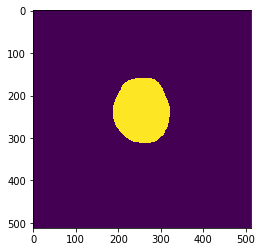

In [24]:
plt.imshow(cv2.imread(df.loc[88,'Segm'], cv2.IMREAD_GRAYSCALE))